# Modeling and Simulation in Python

Case Study: Two Factor Autentication Simulation

Copyright 2018 Michael Moser Mucelin

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
%matplotlib inline

%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module - Copyright 2017 Allen Downey
from modsim import *

# set the random number generator
np.random.seed(7)

## Variables


`lam` estimate time of arrival expressed in 1/Time in seconds

`mu` avarege number of time for completion in minutes expressed by 1/Time in seconds

In [2]:
#Define System Creation
def make_system(lam, mu, duration):
    """Make a System object.
    
    lam: arrival rate, per second
    mu: service completion rate, per second
    dration: Time in seconds to simulate
    
    returns: System object
    """
    return System(lam=lam, mu=mu, duration=duration)

In [3]:
interarrival_time =  20
service_time = 5

lam = 1 / interarrival_time
mu = 1 / service_time
duration = 10*60*60

system = make_system(lam, mu, duration)

lam             0.05
mu              0.20
duration    36000.00
dtype: float64

In [4]:
# Update function ECC Curent implementation (Performance)

def update_ecc_performace(x, t, system):
    """Simulate one time step.
    
    x: number of request in the server
    t: time step
    system: System object
    """
    # if there's a request in the server, check if decryption is done
    if x > 0:
        if flip(system.mu):
            x -= 1
            
    # check for an arrival
    if flip(system.lam):
        x += 1
        
    return x

# Update function ECC 2 Factor implementation (Performance)
def update_ecc_2factor_performance(x, y, z, t, system) :
    """Simulate one time step.
    
    x: number of request in the server
    y: number of request in the autentication server
    z: number of requests from autentication server to server
    t: time step
    system: System object
    """
    
    # if there's a request in the server, check if decryption is done
    if z > 0:
        if flip(system.mu):
            z -= 1
    
    # if there's a request in the server, check if decryption is done
    if y > 0:
        if flip(system.mu):
            y -= 1
            z += 1
    
    # if there's a request in the server, check if decryption is done
    if x > 0:
        if flip(system.mu):
            x -= 1
            y += 1
            
    # check for an arrival
    if flip(system.lam):
        x += 1
        
    return x, y, z

In [5]:
# Test
test = [None] * 2
test[0] = update_ecc_performace(1, 0, system)
test[1] = update_ecc_2factor_performance(1, 0, 0, 0, system)
test

x,y,z = update_ecc_2factor_performance(1, 0, 0, 0, system)
z

0

In [6]:
def run_simulation_ecc(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x = 0
    results = TimeSeries()
    results[0] = x
    
    for t in linrange(0, system.duration):
        x = update_func(x, t, system)
        results[t+1] = x

    return results

def run_simulation_ecc_2factor(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x = 0
    y = 0
    z = 0
    resultsX = TimeSeries()
    resultsY = TimeSeries()
    resultsZ = TimeSeries()
    resultsX[0] = x
    resultsY[0] = y
    resultsZ[0] = z
    
    for t in linrange(0, system.duration):
        x, y, z = update_func(x, y, z, t, system)
        resultsX[t+1] = x
        resultsY[t+1] = y
        resultsZ[t+1] = z

    return resultsX, resultsY, resultsZ

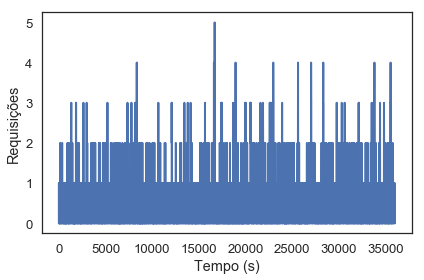

In [8]:
# Solution ECC

results = run_simulation_ecc(system, update_ecc_performace)
plot(results)
decorate(xlabel='Tempo (s)', ylabel='Requisições')

In [ ]:
# Solution ECC 2Factor

resultsX, resultsY, resultsZ = run_simulation_ecc_2factor(system, update_ecc_2factor_performance)

plot(resultsX)
decorate(xlabel='Tempo (s)', ylabel='Requisições')

In [ ]:
plot(resultsY)
decorate(xlabel='Tempo (s)', ylabel='Requisição para o autenticador')

In [ ]:
plot(resultsZ)
decorate(xlabel='Tempo (s)', ylabel='Requisições do autenticador para o servidor')

In [ ]:
def compute_metrics(results, system):
    """Compute average number of requests and wait time.
    
    results: TimeSeries of queue lengths
    system: System object
    
    returns: L, W
    """
    L = results.mean()
    W = L / system.lam
    return L, W

In [ ]:
# ECC Performance
compute_metrics(results, system)

In [ ]:
#Ecc 2 Factor Performance

compute_metrics(resultsX, system)

In [ ]:
compute_metrics(resultsY, system)

In [ ]:
compute_metrics(resultsZ, system)

## Sweeping

In [ ]:
num_vals = 101
lam_array = linspace(0.1*mu, 0.8*mu, num_vals)
lam_array

In [ ]:
# Solution

def sweep_lam_ecc(lam_array, mu, duration, simulation, update_func):
    """Run simulations with a range of values for `lam`
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    simulation: simultion to be used  
    update_func: passed along to run_simulation
    
    returns: SweepSeries of average wait time vs lam
    """
    sweep = SweepSeries()
    
    for lam in lam_array:
        system = make_system(lam, mu, duration)
        results = simulation(system, update_func)
        L, W = compute_metrics(results, system)
        sweep[lam] = W
        
    return sweep

def sweep_lam_ecc_2factor(lam_array, mu, duration, simulation, update_func):
    """Run simulations with a range of values for `lam`
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    simulation: simultion to be used  
    update_func: passed along to run_simulation
    
    returns: SweepSeries of average wait time vs lam
    """
    sweepX = SweepSeries()
    sweepY = SweepSeries()
    sweepZ = SweepSeries()
    for lam in lam_array:
        system = make_system(lam, mu, duration)
        resultsX, resultsY, resultsZ = simulation(system, update_func)
        L, W = compute_metrics(resultsX, system)
        sweepX[lam] = W
        
        L, W = compute_metrics(resultsY, system)
        sweepY[lam] = W
        
        L, W = compute_metrics(resultsZ, system)
        sweepZ[lam] = W
        
    return sweepX, sweepY, sweepZ

In [ ]:
# Solution
sweep_ecc = sweep_lam_ecc(lam_array, mu, 10*60, run_simulation_ecc, update_ecc_performace)

sweep2X, sweep2Y, sweep2Z = sweep_lam_ecc_2factor(lam_array, mu, 10*60, run_simulation_ecc_2factor, update_ecc_2factor_performance)

In [ ]:
# Solution

plot(sweep_ecc, 'bo')

decorate(xlabel='Tempo médio entre chegadas, lambda (por s)',
         ylabel='Média de tempo no sistema',
         title='ECC implementação atual')

In [ ]:
plot(sweep2X, 'bo')

decorate(xlabel='Tempo médio entre chegadas, lambda (por s)',
         ylabel='Média de tempo no sistema',
         title='ECC 2 fatores servidor')

In [ ]:
plot(sweep2Y, 'bo')

decorate(xlabel='Tempo médio entre chegadas, lambda (por s)',
         ylabel='Média de tempo no sistema',
         title='ECC 2 fatores autenticador')

In [ ]:
plot(sweep2Z, 'bo')

decorate(xlabel='Tempo médio entre chegadas, lambda (por s)',
         ylabel='Média de tempo no sistema',
         title='ECC 2 fatores autenticador para servidor')

In [ ]:
# W_avg = sweep.mean()

In [ ]:
def plot_W(lam_array, mu):
    """Plot the theoretical mean wait time.
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    """
    W = 1 / (mu - lam_array)
    plot(lam_array, W, 'g-')

In [ ]:
# Solution

plot_W(lam_array, mu)
plot(sweep_ecc, 'bo')

decorate(xlabel='Tempo médio entre chegadas, lambda (por s)',
         ylabel='Média de tempo no sistema',
         title='ECC implementação atual')

In [ ]:
sweep_ecc

#lam - W

In [ ]:
plot_W(lam_array, mu)
plot(sweep2X, 'bo')

decorate(xlabel='Tempo médio entre chegadas, lambda (por s)',
         ylabel='Média de tempo no sistema',
         title='ECC 2 fatores servidor')

In [ ]:
sweep2X

In [ ]:
plot_W(lam_array, mu)
plot(sweep2Y, 'bo')

decorate(xlabel='Tempo médio entre chegadas, lambda (por s)',
         ylabel='Média de tempo no sistema',
         title='ECC 2 fatores autenticador')

In [ ]:
sweep2Y

In [ ]:
plot_W(lam_array, mu)
plot(sweep2Z, 'bo')

decorate(xlabel='Tempo médio entre chegadas, lambda (por s)',
         ylabel='Média de tempo no sistema',
         title='ECC 2 fatores autenticador para servidor')

In [ ]:
sweep2Z